In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For datetime conversion
from datetime import datetime

# For regression modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df0 = pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")


In [2]:
# Shape and Info
print(df0.shape)
print(df0.info())

# Check missing and duplicates
print(df0.isna().sum())
print(f'Duplicates: {df0.duplicated().sum()}')

# Descriptive statistics
print(df0.describe())


(22699, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  flo

In [3]:
# Check format
print(df0[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].head())

# Convert
df0['tpep_pickup_datetime'] = pd.to_datetime(df0['tpep_pickup_datetime'])
df0['tpep_dropoff_datetime'] = pd.to_datetime(df0['tpep_dropoff_datetime'])


     tpep_pickup_datetime   tpep_dropoff_datetime
0   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM
1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM
2   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM
3   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM
4  04/15/2017 11:32:20 PM  04/15/2017 11:49:03 PM


In [4]:
df0['duration'] = (df0['tpep_dropoff_datetime'] - df0['tpep_pickup_datetime']).dt.total_seconds() / 60


       trip_distance   fare_amount      duration
count   22699.000000  22699.000000  22699.000000
mean        2.913313     13.026629     17.013777
std         3.653171     13.243791     61.996482
min         0.000000   -120.000000    -16.983333
25%         0.990000      6.500000      6.650000
50%         1.610000      9.500000     11.183333
75%         3.060000     14.500000     18.383333
max        33.960000    999.990000   1439.550000


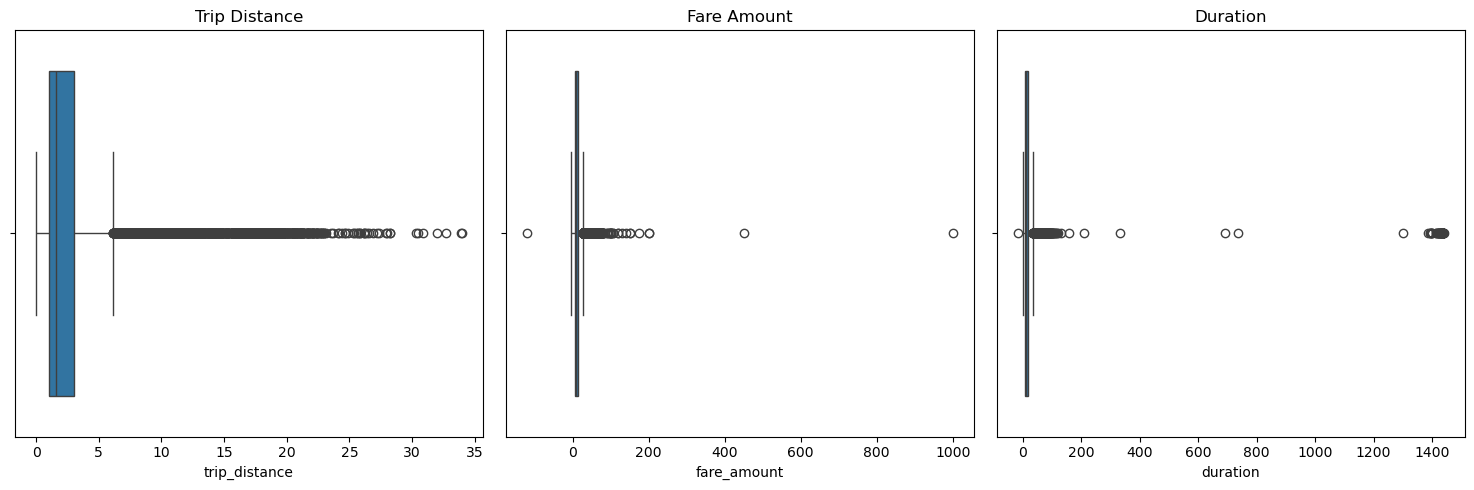

In [5]:
# Check relevant columns
print(df0[['trip_distance', 'fare_amount', 'duration']].describe())

# Box plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x=df0['trip_distance'], ax=axs[0])
sns.boxplot(x=df0['fare_amount'], ax=axs[1])
sns.boxplot(x=df0['duration'], ax=axs[2])
axs[0].set_title("Trip Distance")
axs[1].set_title("Fare Amount")
axs[2].set_title("Duration")
plt.tight_layout()
plt.show()


In [6]:
# Check smallest unique distances
print(sorted(df0['trip_distance'].unique())[:10])

# Count of zero distances
print((df0['trip_distance'] == 0).sum())


[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
148


In [7]:
# Negative fare amounts
df0.loc[df0['fare_amount'] < 0, 'fare_amount'] = 0

# Impute upper outliers
Q1 = df0['fare_amount'].quantile(0.25)
Q3 = df0['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
upper_threshold = Q3 + 6 * IQR
df0.loc[df0['fare_amount'] > upper_threshold, 'fare_amount'] = upper_threshold


In [8]:
# Negative durations
df0.loc[df0['duration'] < 0, 'duration'] = 0

# High duration outliers
Q1_d = df0['duration'].quantile(0.25)
Q3_d = df0['duration'].quantile(0.75)
IQR_d = Q3_d - Q1_d
upper_threshold_d = Q3_d + 6 * IQR_d
df0.loc[df0['duration'] > upper_threshold_d, 'duration'] = upper_threshold_d


In [9]:
# Create pickup_dropoff
df0['pickup_dropoff'] = df0['PULocationID'].astype(str) + " " + df0['DOLocationID'].astype(str)

# Group and calculate mean
grouped = df0.groupby('pickup_dropoff')['trip_distance'].mean()
grouped_dict = grouped.to_dict()

# Map to new column
df0['mean_distance'] = df0['pickup_dropoff'].map(grouped_dict)
